In [88]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [89]:
# set working directory
working_dir = "/projects/bcnx/kazumak2/MIMONet/LDC/"
data_dir = os.path.join(working_dir, "data")

In [183]:
train_branch = np.load(os.path.join(data_dir, "training/train_branch_input.npy"))

In [90]:

# trunk dataset
trunk_input = np.load(os.path.join(data_dir, "share/coords.npy"))

# set x and y coordinates
x = trunk_input[:, 0]
y = trunk_input[:, 1]

# scale0to1
def scale0to1(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())
# scale x and y
x = scale0to1(x)
y = scale0to1(y)

In [91]:
results_dir = os.path.join(working_dir, "results")
data = np.load(os.path.join(results_dir, "test_results.npz"))
pred = data['pred']
gt_target = data['target']

print(f"Predictions shape: {pred.shape}, Targets shape: {gt_target.shape}")

Predictions shape: (988, 4225, 3), Targets shape: (988, 4225, 3)


In [92]:
# Compute L2 norm over grid points for each sample and channel
l2_pred = np.linalg.norm(pred, axis=1)  # shape: (samples, channels)
l2_gt = np.linalg.norm(gt_target, axis=1)  # shape: (samples, channels)

# Compute L2 error over grid points for each sample and channel
l2_err = np.linalg.norm(pred - gt_target, axis=1)  # shape: (samples, channels)

# Compute relative error (avoid division by zero)
rel_err = l2_err / (l2_gt + 1e-8)  # shape: (samples, channels)

In [93]:
import pandas as pd

df = pd.DataFrame()

df['ch0'] = rel_err[:, 0] * 100  # Convert to percentage
df['ch1'] = rel_err[:, 1] * 100  # Convert to percentage
df['ch2'] = rel_err[:, 2] * 100  # Convert to percentage

# compute the mean over all channel per sample
df['mean'] = df.mean(axis=1)

# get the idx of the maximum mean and minimum mean also 50th percentile
df['50th_percentile'] = df['mean'].quantile(0.5)
# find the idx for 50th percentile
percentile_idx = df['mean'].sub(df['50th_percentile']).abs().idxmin()
print(f"Sample with 50th percentile mean relative error: {percentile_idx}, Mean: {df['mean'][percentile_idx]}")

print(df.iloc[percentile_idx])

Sample with 50th percentile mean relative error: 196, Mean: 2.6192843914031982
ch0                1.520653
ch1                4.057989
ch2                2.279210
mean               2.619284
50th_percentile    2.619322
Name: 196, dtype: float64


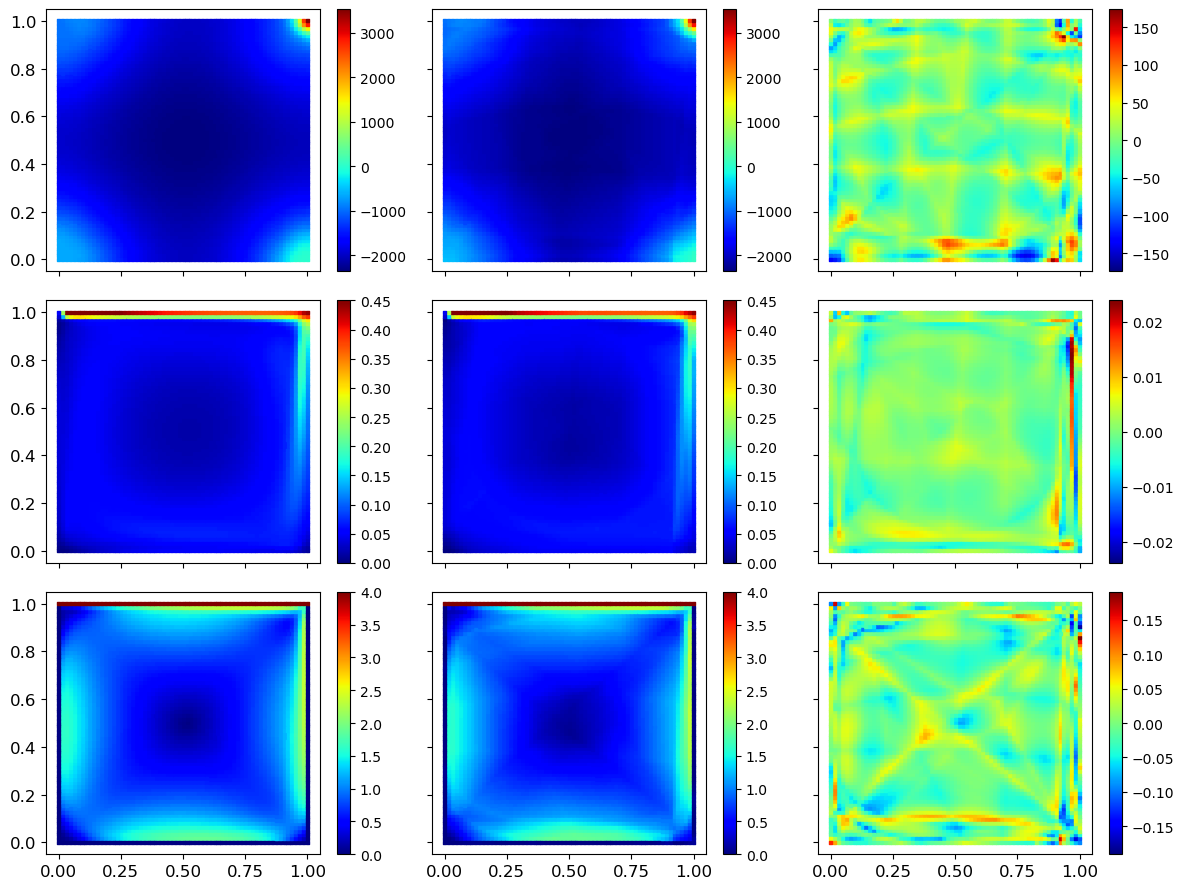

In [155]:
import matplotlib.pyplot as plt
import numpy as np

# Create figure and axes
fig, ax = plt.subplots(3, 3, figsize=(12, 9), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.1, hspace=0.1)

# Loop over 3 channels
for ch in range(3):
    gt = gt_target[percentile_idx, :, ch]
    pr = pred[percentile_idx, :, ch]
    diff = gt - pr

    # Set consistent color range for GT and prediction
    if ch == 0:
        vmin = gt.min()
        vmax = gt.max()
    if ch == 1:
        vmin = 0.0
        vmax = 0.45
    if ch == 2:
        vmin = gt.min()
        vmax = 4

    # Symmetric range for the difference plot
    vmax_diff = np.abs(diff).max()

    # Ground Truth
    im0 = ax[ch, 0].scatter(x, y, c=gt, cmap='jet', s=5, marker='s', vmin=vmin, vmax=vmax)
    fig.colorbar(im0, ax=ax[ch, 0], orientation='vertical')

    # Prediction
    im1 = ax[ch, 1].scatter(x, y, c=pr, cmap='jet', s=5, marker='s', vmin=vmin, vmax=vmax)
    fig.colorbar(im1, ax=ax[ch, 1], orientation='vertical')

    # Difference
    im2 = ax[ch, 2].scatter(x, y, c=diff, cmap='jet', s=5, marker='s', vmin=-vmax_diff, vmax=vmax_diff)
    fig.colorbar(im2, ax=ax[ch, 2], orientation='vertical')

# tick label size
for i in range(3):
    ax[i, 0].tick_params(axis='both', which='major', labelsize=12)
    ax[i, 1].tick_params(axis='both', which='major', labelsize=12)
    ax[i, 2].tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.savefig(os.path.join(working_dir, "analysis/ldc_sample_50th_percentile.png"), dpi=300)
plt.show()


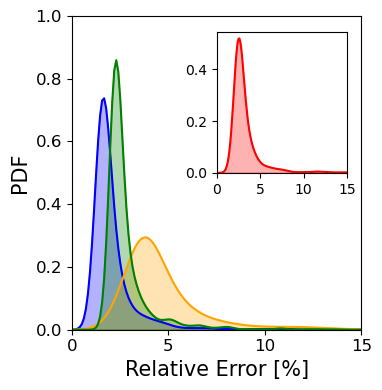

In [184]:
from scipy.stats import gaussian_kde
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, ax = plt.subplots(1, 1, figsize=(4, 4))

# Scale to percentage
p_vals = rel_err[:, 0] * 100
v_vals = rel_err[:, 1] * 100
k_vals = rel_err[:, 2] * 100
mean_vals = df['mean']

# Compute KDEs
p_kde = gaussian_kde(p_vals)
v_kde = gaussian_kde(v_vals)
k_kde = gaussian_kde(k_vals)
mean_kde = gaussian_kde(mean_vals)

# Define evaluation range
x_eval = np.linspace(0, max(p_vals.max(), v_vals.max(), k_vals.max(), mean_vals.max()), 500)
p_pdf = p_kde(x_eval)
v_pdf = v_kde(x_eval)
k_pdf = k_kde(x_eval)
mean_pdf = mean_kde(x_eval)

# Main plot
ax.plot(x_eval, p_pdf, label='$p$', color='blue')
ax.fill_between(x_eval, p_pdf, alpha=0.3, color='blue')

ax.plot(x_eval, v_pdf, label='$\|\mathbf{v}(x,y)\|$', color='orange')
ax.fill_between(x_eval, v_pdf, alpha=0.3, color='orange')

ax.plot(x_eval, k_pdf, label='$k^2$', color='green')
ax.fill_between(x_eval, k_pdf, alpha=0.3, color='green')

#ax.plot(x_eval, mean_pdf, label='Mean', color='red')
#ax.fill_between(x_eval, mean_pdf, alpha=0.3, color='red')

# Labels and limits
ax.set_xlabel('Relative Error [%]', fontsize=15)
ax.set_ylabel('PDF', fontsize=15)
ax.set_xlim(0, 15)
ax.set_ylim(0, 1.0)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()

# === NEW: Add subplot inside the blue region ===
# Define pixel-aligned region inside the main axes [x0, y0, width, height] in axes coords
inset = ax.inset_axes([0.5, 0.5, 0.45, 0.45])  # Adjust as needed (x0, y0, w, h)

inset.plot(x_eval, mean_pdf, color='red')
inset.fill_between(x_eval, mean_pdf, alpha=0.3, color='red')
inset.set_xlim(0, 15)  # Zoomed-in x-range for mean
inset.set_ylim(0, max(mean_pdf) * 1.05)
#inset.set_xticks([])
#inset.set_yticks([])
#$inset.set_title("Mean PDF", fontsize=9)

plt.savefig(os.path.join(working_dir, "analysis/ldc_pdf.png"), dpi=300)
plt.show()


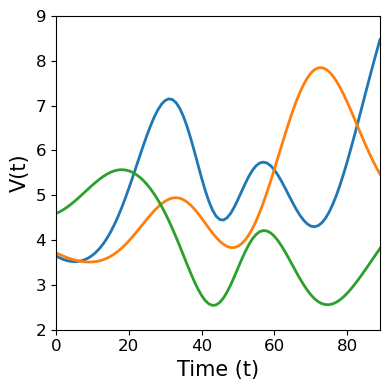

In [222]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

# set the linewidth bold
ax.plot(train_branch[0, :], linewidth=2)
ax.plot(train_branch[1429, :], linewidth=2)
ax.plot(train_branch[133, :], linewidth=2)

ax.set_xlabel('Time (t)', fontsize=15)
ax.set_ylabel('V(t)', fontsize=15)
ax.set_xlim(0, 89)
ax.set_ylim(2, 9)
ax.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.savefig(os.path.join(working_dir, "analysis/ldc_input.png"), dpi=300)
plt.show()